GET THE ORIGINAL DATA.  
GENERATE MATRIX FOR X,  
WITH X FROM **'op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'size_d1', 'size_d2'**  
WITH Y FROM **'anual_cc_return_future'**

In [126]:
isGoogleColab = False

if(isGoogleColab):
    from google.colab import drive
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import math

In [2]:
industry_dict = {'Accommodation and Food Services':'Services',
       'Administrative and Support and Waste Management and Remediation Services':'Services',
       'Agriculture, Forestry, Fishing and Hunting':'Agriculture',
       'Arts, Entertainment, and Recreation':'Services', 
       'Construction':'Construction',
       'Educational Services':'Services', 
       'Finance and Insurance':'Finance',
       'Health Care and Social Assistance':'Services', 
       'Information':'Services',
       'Manufacturing':'Manufacturing', 
       'Mining, Quarrying, and Oil and Gas Extraction':'Mining',
       'Other Services (except Public Administration)':'Services',
       'Professional, Scientific, and Technical Services':'Services',
       'Real Estate and Rental and Leasing':'Finance', 
       'Retail Trade':'Comercial',
       'Transportation and Warehousing':'Services', 
       'Utilities':'Energy', 
       'Wholesale Trade':'Comercial'}

In [3]:
if(isGoogleColab):
    drive.mount("/content/gdrive") 
    %cd "/content/gdrive/MyDrive/Machine Learning/deliver/M1"
df = pd.read_csv('us2022q2a.csv')
df_firm = pd.read_csv('usfirms2022.csv')

In [4]:
bIsAproachNew = False

df_more = df.copy()

#put industry column
firm_list = df['firm'].unique()
firm_list = firm_list.tolist()
firm_list.remove(np.nan)
df_firm_more = df_firm.copy()
df_firm_more['industry'] = df_firm_more['Sector NAICS\nlevel 1']
df_firm_more = df_firm_more.replace({'industry': industry_dict})

firm_industry_dic = {}

if(bIsAproachNew):
  firm_industry_dic_temp = {}

  for count in range(df_firm_more['Ticker'].count()):
    firm_industry_dic_temp[df_firm_more['Ticker'][count]] = df_firm_more['industry'][count]

  #print(firm_industry_dic_temp)
else:
  for firm in firm_list:
    if (len((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist()) > 0):
      firm_industry_dic[firm] = ((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist())[0]
    else:
      firm_industry_dic[firm] = np.nan

for firm in firm_list:
    if(bIsAproachNew):
      if((len(firm) > 0) and (firm in firm_industry_dic_temp)):
        firm_industry_dic[firm] = firm_industry_dic_temp[firm]
      #else:
      #  firm_industry_dic[firm] = np.nan
    else:
      if(len(firm) > 0):
        #firm_industry_dic[firm] = ((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist())[0]
        temp_df = df_firm_more[df_firm_more['Ticker'] == firm]
        if(temp_df['industry'].count() > 0):
          firm_industry_dic[firm] = temp_df['industry'].tolist()[0]
      #else:
      #  firm_industry_dic[firm] = np.nan

df_more['industry'] = df_more['firm']
df_more = df_more.replace({'industry': firm_industry_dic})


#put country column
firm_country_dict = {}
for count in range(df_firm['Ticker'].count()):
    firm = df_firm['Ticker'][count]
    country = df_firm['Country\nof Origin'][count]
    firm_country_dict[firm] = country

df_more['country'] = df_more['firm']
df_more = df_more.replace({'country':firm_country_dict})
#drop the line which all column is empty
df_more = df_more.dropna(how='all')
#df_more

In [5]:
df_more['firm_index'] = df_more['firm']
df_more['q_index'] = df_more['q']
df_more.set_index(['firm_index','q_index'], inplace=True)
#add Date
df_more['date'] = pd.to_datetime(df_more['q'])

#Calculate bookvalue
df_more['bookvalue'] = df_more['totalassets'] - df_more['totalliabilities']

#Calculate Market Value
df_more['marketvalue'] = df_more['originalprice'] * df_more['sharesoutstanding']

#Calculate Operating profit margin
df_more['op_profit'] = df_more['revenue'] - df_more['cogs'] - df_more['sgae'] - df_more['otheropexp']
df_more['op_profit_margin'] = df_more['op_profit'] / df_more['revenue']
df_more['net_income'] = df_more['op_profit'] - df_more['incometax'] - df_more['finexp'] + df_more['extraincome']
df_more['profit_margin'] = df_more['net_income'] / df_more['revenue']

#Calculate CC Return
df_more['anual_cc_return'] = np.log(df_more['adjprice']) - np.log(df_more['adjprice'].shift(4))
df_more['anual_cc_return_future'] = np.log(df_more['adjprice'].shift(-1)) - np.log(df_more['adjprice'].shift(3))


#Earning Per Share
df_more['eps'] = df_more['net_income'] / df_more['sharesoutstanding']

#Calculate the short term leverage

#Calculate the ratio of bookvalue and market value


df_more = df_more.dropna(subset=['adjprice'])

In [6]:
industry_list = df_more['industry'].unique()
industry_list = industry_list.tolist()
del industry_list[-1]
del industry_list[-1]

In [7]:
df_more.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
df_more_clean = df_more.dropna(subset=['op_profit_margin', 'anual_cc_return', 'eps'])
winsorize(df_more_clean['op_profit_margin'], limits=[0.01,0.01],  inplace=True)
winsorize(df_more_clean['anual_cc_return'], limits=[0.01,0.01],inplace=True)
winsorize(df_more_clean['eps'], limits=[0.01,0.01], inplace=True)

masked_array(data=[ 0.33715018,  0.21003221, -0.47542827, ...,
                    0.28896335, -1.12921415, -0.44195264],
             mask=False,
       fill_value=1e+20)

In [9]:
df_more['epsp'] = df_more['eps'] / df_more['originalprice']

In [10]:
df_finance = df_more[df_more['industry'] == 'Finance'].copy()
df_finance['short_leverage'] = df_finance['shortdebt'] / df_finance['totalassets']
df_finance['bmr'] = df_finance['bookvalue'] / df_finance['marketvalue']

df_finance.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
df_finance_train = df_finance.copy()
df_finance_train = df_finance_train.dropna(subset=['op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'anual_cc_return_future'])

In [12]:
df_finance_train['op_profit_margin'] = winsorize(df_finance_train['op_profit_margin'], limits=[0.01,0.01])
df_finance_train['short_leverage'] = winsorize(df_finance_train['short_leverage'], limits=[0.01,0.01])
df_finance_train['bmr'] = winsorize(df_finance_train['bmr'], limits=[0.01,0.01])
df_finance_train['epsp'] = winsorize(df_finance_train['epsp'], limits=[0.01,0.01])

In [13]:
df_finance_train['size_d1'] = 0
df_finance_train['size_d2'] = 0

In [14]:
df_finance_train_copy = df_finance_train.copy()
df_finance_train_date_size = df_finance_train_copy.sort_values(['date', 'marketvalue']).groupby('date')
df_finance_train_date_size[['marketvalue', 'date', 'q']].head()
#len(df_finance_train_date_size['date'].unique())
#df_finance_train_date_size['date'].head()

count = 0
for date in df_finance_train_copy['date'].unique():
    df_date = df_finance_train_copy.loc[df_finance_train_copy['date'] == date]
    
    size_total = df_date['marketvalue'].count()
    size_per = size_total // 3
    
    df_date_size_sort = df_date.sort_values('marketvalue')
    #df_date_size_sort.reset_index()
    #if(count == 0):
    #    print(df_date_size_sort[['size_d1', 'marketvalue']].head())
    #df_date_size_sort['size_d1'].iloc[size_per:(2 * size_per - 1)] = 1
    #df_date_size_sort['size_d2'].iloc[(2 * size_per) :] = 1

    for firm in df_date_size_sort['firm'].iloc[size_per:(2 * size_per - 1)]:
        df_finance_train_copy.loc[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date), 'size_d1'] = 1
        #if(count == 0):
        #    print(df_finance_train_copy[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date)].index.to_list()[0])

    for firm in df_date_size_sort['firm'].iloc[(2 * size_per) :]:
        df_finance_train_copy.loc[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date), 'size_d2'] = 1


    count += 1

#print(count)
#df_finance_train_copy.isna().sum()
#df_finance_train_copy[['date', 'marketvalue', 'size_d1', 'size_d2']].head(40)
#print(df_finance_train_copy['size_d1'].unique())
#print(df_finance_train_copy['size_d2'].unique())

CHOOSE THE X AND Y FOR LINEAR REGRESSION

In [ ]:
X = df_finance_train_copy[['op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'size_d1', 'size_d2']]
y = df_finance_train_copy['anual_cc_return_future']

ADD THE CONSTANCE FOR THE X MATRIX  
AND DO THE LINEAR REGRESSION FROM PYTHON DIRECTLY

In [ ]:
X_C = sm.add_constant(X)
mkmodel = sm.OLS(y,X_C).fit()
mkmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     anual_cc_return_future   R-squared:                       0.069
Model:                                OLS   Adj. R-squared:                  0.068
Method:                     Least Squares   F-statistic:                     90.87
Date:                    Wed, 26 Oct 2022   Prob (F-statistic):          2.06e-110
Time:                            00:32:37   Log-Likelihood:                -5522.4
No. Observations:                    7346   AIC:                         1.106e+04
Df Residuals:                        7339   BIC:                         1.111e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1238      0.013      9.699      0.000       0.099       0.149
op_profit_margin     0.0451      0.013      3.481      0.001       0.020       0.071
short_leverage      -0.1818      0.060     -3.039      0.002      -0.299      -0.065
bmr                 -0.1095      0.009    -11.812      0.000      -0.128      -0.091
epsp                 1.9439      0.137     14.144      0.000       1.674       2.213
size_d1              0.0121      0.015      0.800      0.424      -0.018       0.042
size_d2              0.0181      0.015      1.200      0.230      -0.012       0.048
==============================================================================
Omnibus:                     1970.316   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54621.546
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                      16.289   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 1 Perform an exploratory analysis of the variables:(You have to use matrix algebra and check results with Python functions.)

## 1.1 Calculates variance and covariance matrix,   
## as well as correlation matrix of the independent and dependent variables

TURN THE X Y AND X WITH CONSTANCE TO THE NUMPY MATRIX

In [226]:
X_Mat = X.to_numpy()
X_C_Mat = X_C.to_numpy()
Y_Mat = y.to_numpy()

### **CALCULATE CORRELATION MATRIX**  
CORR_MAT = NORMAL(X)' .  NORMAL(X)

CALCULATE THE MEAN OF X_MAT

In [227]:
N = X_Mat.shape[0]
X_Mean_Sig_Mat =  (np.ones((1, N))).dot(X_Mat) / N

In [228]:
X_Mean_Mat = (np.ones((N, 1))).dot(X_Mean_Sig_Mat)

CALCULATE THE STANDARD DEVIATION OF X_MAT

In [229]:
X_E_Mat = X_Mat - X_Mean_Mat

In [230]:
X_SE_Sig_Mat = np.sqrt(np.ones((1, N)).dot((X_E_Mat * X_E_Mat)) / (N - 1)) #/ math.sqrt(N)

In [231]:
X_SE_Mat = np.ones((N,1)).dot(X_SE_Sig_Mat)

NORMALIZE THE X_MAT

In [225]:
X_Norm_Mat = X_E_Mat / X_SE_Mat

CALCULATE THE CORRELATION MATRIX OF X_MAT

In [218]:
Corr_Mat = (X_Norm_Mat.transpose()).dot(X_Norm_Mat)
Normal = Corr_Mat[0,0]
Corr_Mat = Corr_Mat / Normal
Corr_Mat

array([[ 1.        , -0.00954724, -0.09703459,  0.37558602,  0.02214399,
         0.14547849],
       [-0.00954724,  1.        ,  0.07404696, -0.010406  ,  0.07816235,
        -0.07224123],
       [-0.09703459,  0.07404696,  1.        , -0.14765687, -0.05835378,
        -0.170659  ],
       [ 0.37558602, -0.010406  , -0.14765687,  1.        ,  0.06215465,
         0.10128666],
       [ 0.02214399,  0.07816235, -0.05835378,  0.06215465,  1.        ,
        -0.49113187],
       [ 0.14547849, -0.07224123, -0.170659  ,  0.10128666, -0.49113187,
         1.        ]])

VERIFY WITH PYTHON CODE

In [196]:
#np.correlate(X_Mat, X_Mat)
X.corr()


,op_profit_margin,short_leverage,bmr,epsp,size_d1,size_d2
op_profit_margin,1.000000,-0.009547,-0.097035,0.375586,0.022144,0.145478
short_leverage,-0.009547,1.000000,0.074047,-0.010406,0.078162,-0.072241
bmr,-0.097035,0.074047,1.000000,-0.147657,-0.058354,-0.170659
epsp,0.375586,-0.010406,-0.147657,1.000000,0.062155,0.101287
size_d1,0.022144,0.078162,-0.058354,0.062155,1.000000,-0.491132
size_d2,0.145478,-0.072241,-0.170659,0.101287,-0.491132,1.000000


## Interpret the correlation matrix.

CORRELATION MATRIX INDICATE THE CORRELATION BETWEEN EACH INDEPENDENT VARIABLES  
IT IS BETWEEN -1 TO 1

VarCov(X) = (1/(N - 1)) ( X'.X - (1/N)*(X'.1).(X'.1) )

In [234]:
VarCov_Mat = ((X_Mat.transpose()).dot(X_Mat) - np.square((X_Mat.transpose()).dot(np.ones((N,1))))/N)/(N-1)
VarCov_Mat

array([[ 2.53174399e-01, -1.25669057e-02,  2.70537373e-02,
        -8.11263189e-03,  2.96195907e-02,  6.26491380e-02],
       [ 3.41634333e-03,  1.01522736e-02,  2.82165754e-02,
        -1.66912234e-03,  1.54518836e-02,  9.45541582e-03],
       [-2.93129053e-01, -3.07949464e-01,  4.50336091e-01,
        -3.39501933e-01, -1.72215243e-01, -1.93233484e-01],
       [ 9.69884925e-03,  1.59109747e-04, -1.50766223e-03,
         2.26123515e-03,  3.10508469e-03,  4.16076934e-03],
       [-5.27230772e-02, -8.28740334e-02,  6.56248797e-02,
        -9.70490643e-02,  2.16356753e-01, -1.00185113e-01],
       [-3.68301719e-02, -1.06007143e-01,  2.74699959e-02,
        -1.13130022e-01, -1.17321755e-01,  2.25224195e-01]])

VARIANCE

In [238]:
(VarCov_Mat * np.eye(VarCov_Mat.shape[0])).dot(np.ones((VarCov_Mat.shape[0], 1)))

array([[0.2531744 ],
       [0.01015227],
       [0.45033609],
       [0.00226124],
       [0.21635675],
       [0.2252242 ]])

VARIFY WITH PYTHON CODE

In [ ]:
X.var()

op_profit_margin    0.253174
short_leverage      0.010152
bmr                 0.450336
epsp                0.002261
size_d1             0.216357
size_d2             0.225224
dtype: float64

In [ ]:
X.cov()

,op_profit_margin,short_leverage,bmr,epsp,size_d1,size_d2
op_profit_margin,0.253174,-0.000484,-0.032765,0.008987,0.005183,0.034739
short_leverage,-0.000484,0.010152,0.005007,-0.000050,0.003663,-0.003454
bmr,-0.032765,0.005007,0.450336,-0.004712,-0.018215,-0.054351
epsp,0.008987,-0.000050,-0.004712,0.002261,0.001375,0.002286
size_d1,0.005183,0.003663,-0.018215,0.001375,0.216357,-0.108415
size_d2,0.034739,-0.003454,-0.054351,0.002286,-0.108415,0.225224


## Explain what variance, covariance, and correlation are.

**Variance**, is a measure of variability from the mean  

**Covariance**, is a measure of relationship between the variability of 2 variables  
It is the Average of the Product Deviations from the mean of each variable  
We can not understand the magnitude of Covariance   

**Correlation**, is a relationship between the variability of 2 variables  
Correlation is standarized, value between -1 and 1

### Use the Variant Covariant Matrix  
### Run statistical tests to detect outliers and leverage points.  
### You have to use matrix algebra for the proofs and clearly explain how the proofs work.  
### You can use Python functions to check results.

**CALCULATE THE COEFFICIENT MATRIX B**  

B=(X'.X)^(-1) . X' . Y

In [60]:
X_C_T_Mat = X_C_Mat.transpose()
B_Mat = ((np.linalg.inv(X_C_T_Mat.dot(X_C_Mat))).dot(X_C_T_Mat)).dot(Y_Mat)
B_Mat


array([ 0.12378316,  0.0451271 , -0.18181964, -0.10952051,  1.9438988 ,
        0.01210472,  0.01814835])

**CALCULATE HAT MATRIX H**  
Y_H = H . Y
Y_H = X.B
H = X.(X'.X)^(-1).X'

In [63]:
H_Mat = (X_C_Mat.dot(np.linalg.inv(X_C_T_Mat.dot(X_C_Mat)))).dot(X_C_T_Mat)
H_Mat

array([[0.00112381, 0.00062822, 0.00110993, ..., 0.00030945, 0.00032743,
        0.00023321],
       [0.00062822, 0.00057693, 0.00062937, ..., 0.00035475, 0.00049713,
        0.00030562],
       [0.00110993, 0.00062937, 0.00111979, ..., 0.00033705, 0.00066578,
        0.00036171],
       ...,
       [0.00030945, 0.00035475, 0.00033705, ..., 0.00173432, 0.00246757,
        0.00158535],
       [0.00032743, 0.00049713, 0.00066578, ..., 0.00246757, 0.00739518,
        0.00357407],
       [0.00023321, 0.00030562, 0.00036171, ..., 0.00158535, 0.00357407,
        0.00192636]])

In [85]:
H_One_Mat = H_Mat * np.eye(H_Mat.shape[0])
H_One_Mat

array([[0.00112381, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00057693, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00111979, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00173432, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00739518,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00192636]])

**THE THRESHOLD OF LEVERAGE OF EXTREME X VALUES**  
H_MAT > 3*((k + 1) / n)

In [96]:
H_THRESHOLD = 3 * (X_C_Mat.shape[1] / H_Mat.shape[0])
H_THRESHOLD

0.0028586986114892458

In [93]:
row_leverage, col_leverage = np.where(H_One_Mat > H_THRESHOLD)

In [104]:
H_Mat[row_leverage[:10], col_leverage[:10]]

array([0.00286952, 0.00301909, 0.00573383, 0.0077137 , 0.00399231,
       0.0030085 , 0.00329829, 0.00809931, 0.00640198, 0.00616369])

**RED DOT AS THE HIGH LEVERAGE POINT**

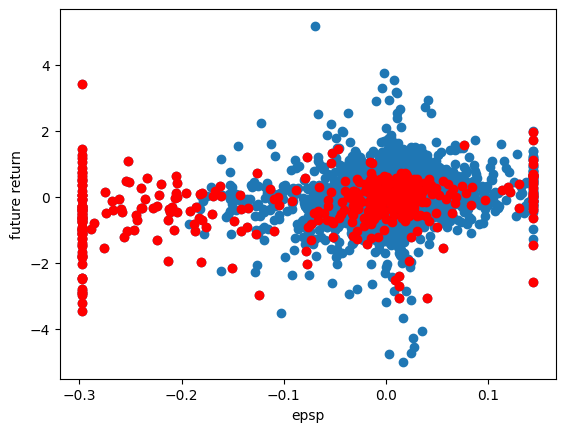

In [112]:
X_Index = 3

plt.scatter(X_Mat[:,X_Index], Y_Mat)
plt.scatter(X_Mat[row_leverage,X_Index], Y_Mat[row_leverage], c='r')
plt.xlabel('epsp')
plt.ylabel('future return')
plt.show()

**IDENTIFY OUTLIERS (UNUSUAL Y VALUE)**  
E = Y - Y_H  
R= E / S(E) = E / SQR( MSE(1 - H) )  

**R > 3 WILL BE OUTLIER**

**CALCULATE THE EXPECT H**  
Y_H = X. B

In [144]:
Y_H_Mat = X_C_Mat.dot(B_Mat)
Y_H_Mat

array([-0.00188818,  0.02978115, -0.04248028, ..., -0.2747532 ,
       -0.88368424, -0.39703753])

**CALCULATE ERROR**  
E = Y - Y_H

In [240]:
E_Mat = Y_Mat - Y_H_Mat
E_Mat = np.reshape(E_Mat, (E_Mat.size, 1))

**CALCULATE MSE**  
MSE = (SQUAR(E))' . ONE / N

In [178]:
MSE = ((E_Mat * E_Mat).transpose()).dot(np.ones(E_Mat.shape)) / E_Mat.shape[0]
MSE = MSE[0][0]
MSE

0.2633244844519785

GET Hii

In [114]:
H_Sig_Mat = H_Mat * np.eye(H_Mat.shape[0])
H_Sig_Mat = H_Sig_Mat.dot(np.ones((H_Mat.shape[0], 1)))
H_Sig_Mat

array([[0.00112381],
       [0.00057693],
       [0.00111979],
       ...,
       [0.00173432],
       [0.00739518],
       [0.00192636]])

**CALCULATE 1 - Hii**

In [118]:
One_Minus_H_Sig_Mat = np.ones(H_Sig_Mat.shape) - H_Sig_Mat
One_Minus_H_Sig_Mat

array([[0.99887619],
       [0.99942307],
       [0.99888021],
       ...,
       [0.99826568],
       [0.99260482],
       [0.99807364]])

**GET OUTLIER**  
R = E / SQRT(MSE * (1 - Hii))

In [184]:
R = E_Mat / np.sqrt(MSE * One_Minus_H_Sig_Mat)

In [185]:
R

array([[ 0.1549869 ],
       [ 0.45088445],
       [ 0.42617757],
       ...,
       [ 0.3321795 ],
       [ 1.16249398],
       [-1.03913804]])

WHEN R > 3, THE Y IS THE OUTLIER

In [186]:
index_outlier,_ = np.where(abs(R) > 3)

In [187]:
index_outlier

array([  65,   66,   67,   73,   74,   75,  198,  236,  237,  343,  346,
        532,  533,  534,  538,  788,  789,  790,  791, 1004, 1005, 1006,
       1093, 1094, 1128, 1129, 1132, 1133, 1177, 1239, 1294, 1308, 1384,
       1406, 1458, 1474, 1478, 1484, 1686, 1714, 1715, 1717, 1723, 1747,
       1782, 1932, 1936, 2042, 2089, 2292, 2320, 2408, 2459, 2460, 2465,
       2466, 2469, 2470, 2544, 2587, 2598, 2599, 2628, 2984, 2985, 3022,
       3214, 3221, 3222, 3316, 3317, 3321, 3443, 3444, 3445, 3817, 3818,
       3819, 3928, 3929, 3932, 3933, 4036, 4060, 4151, 4348, 4349, 4350,
       4645, 4649, 4650, 4651, 4770, 4905, 4906, 4907, 5042, 5301, 5302,
       5303, 5388, 5625, 5800, 5801, 6024, 6025, 6026, 6029, 6030, 6281,
       6282, 6448, 6449, 6450, 6451, 6582, 6587, 6661, 6662, 6754, 6755,
       6756, 6879, 7340])

**DRAW OUTLIER WITH RED DOT** 

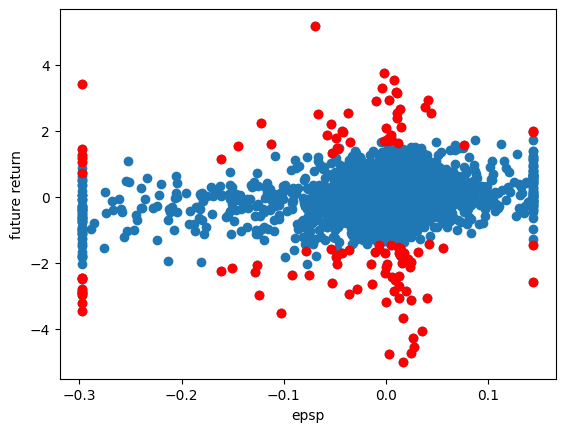

In [188]:
X_Index = 3

plt.scatter(X_Mat[:,X_Index], Y_Mat)
plt.scatter(X_Mat[index_outlier,X_Index], Y_Mat[index_outlier], c='r')
plt.xlabel('epsp')
plt.ylabel('future return')
plt.show()

# Does a multicollinearity analysis explaining the test and implications in the model.

WE CHECK THE CORRELATION MATRIX  
CHECK IF THE CORRELATION IS HIGH OR NOT

In [239]:
Corr_Mat

array([[ 1.00000000e+00,  1.94657234e-02,  1.65658272e-01,
         3.59011367e-02,  1.75125777e-01,  2.96998450e-01],
       [ 1.94657234e-02,  4.43200100e-02,  1.10973807e-01,
         7.01333717e-04,  6.38745508e-02,  4.17487388e-02],
       [ 1.65658272e-01,  1.10973807e-01,  2.90890158e+00,
        -5.44873413e-03,  6.11806963e-01,  5.34253696e-01],
       [ 3.59011367e-02,  7.01333717e-04, -5.44873413e-03,
         8.45777194e-03,  1.15714144e-02,  1.54666876e-02],
       [ 1.75125777e-01,  6.38745508e-02,  6.11806963e-01,
         1.15714144e-02,  1.16797857e+00,  0.00000000e+00],
       [ 2.96998450e-01,  4.17487388e-02,  5.34253696e-01,
         1.54666876e-02,  0.00000000e+00,  1.26392864e+00]])

ALL THE CORRELATION ABS IS SMALLER THAN 0.6  
WE CAN SAY THE INDEPENDENT VARIABLE IS WITH LOW LINEAR RELATION WITH EACH OTHER


# Proposes and implements solutions to the problems of the previous points so that the model is the most appropriate.

**CALCULATE THE COEFFICIENT MATRIX B**  

B=(X'.X)^(-1) . X' . Y

In [ ]:
X_C_T_Mat = X_C_Mat.transpose()
B_Mat = ((np.linalg.inv(X_C_T_Mat.dot(X_C_Mat))).dot(X_C_T_Mat)).dot(Y_Mat)
B_Mat


array([ 0.12378316,  0.0451271 , -0.18181964, -0.10952051,  1.9438988 ,
        0.01210472,  0.01814835])

# Estimate and interpret a multiple regression model after addressing the previous problems. 

## ***INTERPRET THE COEFFICIENCE MAGNITUDE***
***B_CONST = 0.124***  
WHEN THERE IS NO NET INCOME, NOT SHORT DEBT, BOOK_VALUE IS 0, WITH A SMALL OR MEDIA SIZE OF FIRM,  
WE WILL STILL HAVE 12.4% ANNUAL RETURN ON STOCK. 
IT MEANS WITHOUT THE REAL NET INCOME, WE ARE STILL ABLE TO GET ANNUAL RETURN ON STOCK    
THE CAPITAL OPERATION CAN INCREASE THE BOOK VALUE  
***B_OP_PROFIT_MARGIN = 0.045***  
EACH 1% OF PROFIT_MARGIN INCREASE, WILL GIVE A 0.045% OF ANNUAL RETURN INCREASE,  
THE DIFFERENCE OF PROFIT_MARGIN DOES NOT AFFECT TOO MUCH ON THE ANNUAL RETURN.  
SO THE NETINCOME AMOUNT IS THE BIG PART.  
***B_SHORT_LEVERAGE = -0.182***  
EACH 1% OF SHORT_LEVERAGE INCREASE, WILL GIVE 0.182% OF ANNUAL RETURN DECREASE,  
THE SHORT LEVERAGE WILL MAKE A BIG DIFFERENCE ON THE ANNUAL RETURN,  
BECAUSE THE COMPANY NEED TO PAY BACK THE DEBTS IN A SHORT TIME, IT WILL IMPACT HE NET INCOME  
***B_BMR = -0.1095***  
EACH 1% OF BOOK-MARKET-VALUE-RATIO INCREASE, WILL GIVE 0.1095% DECREASE OF ANNUAL RETURN,   
BOOK-MARKET-VALUE-RATIO WILL ALSO AFFECT THE ANNUAL RETURN A LOT,  
SINCE THE NET INCOME WILL BE DIVIDED BY B_BMR IN ORDER TO REFLECT THE INVESTER'S GAIN  
***B_EPSP = 1.94***  
EACH 1% OF EPSP INCREASE, WILL GIVE 1.94% INCREASE ON ANNUAL RETURN,   
IT IS THE BIGGEST IMPACT TO THE ANNUAL RETURN,  
IT IS DUE TO THE EPSP REFLECT THE RETURN RATE OF INVESTMENT ON STOCK MARKET    
***B_SIZE_D2 = 0.0121***  
WHEN COMPANY'S MARKET VALUE IS ABOVE 67.77% TOP STOCK MARKET VALUE,   
THE FIRM'S ANNUAL RETURN WILL HAVE 1.21% MORE ANNUAL RETURN THAN THE COMPANY BELOW 67.77% TOP MARKET VALUE,  



# You have to use matrix algebra to estimate coefficients and standard errors of the regression model, and use Python functions to check results.

**CALCULATE THE EXPECT H**  
Y_H = X. B

In [ ]:
Y_H_Mat = X_C_Mat.dot(B_Mat)
Y_H_Mat

array([-0.00188818,  0.02978115, -0.04248028, ..., -0.2747532 ,
       -0.88368424, -0.39703753])

VARIFY COEFFICIENT FROM PYTHON CODE

In [ ]:
mkmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     anual_cc_return_future   R-squared:                       0.069
Model:                                OLS   Adj. R-squared:                  0.068
Method:                     Least Squares   F-statistic:                     90.87
Date:                    Wed, 26 Oct 2022   Prob (F-statistic):          2.06e-110
Time:                            15:29:17   Log-Likelihood:                -5522.4
No. Observations:                    7346   AIC:                         1.106e+04
Df Residuals:                        7339   BIC:                         1.111e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1238      0.013      9.699      0.000       0.099       0.149
op_profit_margin     0.0451      0.013      3.481      0.001       0.020       0.071
short_leverage      -0.1818      0.060     -3.039      0.002      -0.299      -0.065
bmr                 -0.1095      0.009    -11.812      0.000      -0.128      -0.091
epsp                 1.9439      0.137     14.144      0.000       1.674       2.213
size_d1              0.0121      0.015      0.800      0.424      -0.018       0.042
size_d2              0.0181      0.015      1.200      0.230      -0.012       0.048
==============================================================================
Omnibus:                     1970.316   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54621.546
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                      16.289   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**CALCULATE ERROR**  
E = Y - Y_H

In [241]:
E_Mat = Y_Mat - Y_H_Mat
E_Mat = np.reshape(E_Mat, (E_Mat.size, 1))
N = E_Mat.shape[0]

(7346, 1)

**CALCULATE STANDARD DEVIATION**  
STD = SQRT(SUM(SQUAR(E)) / (N-1))  

SQU_E = E * E  
STD = SQRT(ONE.SQU_E / (N - 1))

In [243]:
Squ_E_Mat = np.square(E_Mat)
Standard_Deviation = np.sqrt((np.ones((1, N))).dot(Squ_E_Mat) / (N - 1))
Standard_Deviation = Standard_Deviation[0][0]
Standard_Deviation

0.5131864527642762

**CALCULATE STANDARD ERROR**  
SE = STD / SQRT(N)  

In [244]:
Standard_Error = Standard_Deviation / math.sqrt(N)
Standard_Error

0.0059875578328877485